In [ ]:
%cd /content/drive/MyDrive/GAN MNIST

/content/drive/MyDrive/GAN MNIST


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input , Dense , BatchNormalization , LeakyReLU 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

In [ ]:
(xtrain , ytrain) , (xtest , ytest) = mnist.load_data()

In [ ]:
xtrain  , xtest = xtrain/255.0*2 -1 , xtest/255.0*2 -1  # performs better if data is centered between -1 and 1

In [ ]:
xtrain.shape

(60000, 28, 28)

In [ ]:
N , H , W = xtrain.shape
D = H*W
xtrain = xtrain.reshape(-1 , D)
xtest  = xtest.reshape(-1 , D)

In [ ]:
gen_dim = 100   # generator input dimensions

In [ ]:
def build_generator(gen_dim):
    i = Input(shape=(gen_dim , ))
    x = Dense(256 , activation = LeakyReLU(0.2))(i)
    x = BatchNormalization()(x)
    x = Dense(512 , activation= LeakyReLU(0.2))(x)
    x = BatchNormalization()(x)
    x = Dense(1024 , activation= LeakyReLU(0.2))(x)
    x = BatchNormalization()(x)
    x = Dense(D , activation="tanh")(x)

    model = Model(i , x)
    
    return model

In [ ]:
def build_discriminator(img_size):
    i = Input(shape = (img_size ,))
    x = Dense(256 , activation = LeakyReLU(0.2))(i)
    x = Dense(512 , activation= LeakyReLU(0.2))(x)
    x = Dense(1 , activation = "sigmoid")(x)

    model = Model(i , x)
    
    return model

In [ ]:
# lets compile both model in preparation for training

# build and compile discriminator model
discriminator = build_discriminator(D)
discriminator.compile(optimizer = Adam(0.0003) , loss = "binary_crossentropy" , metrics = ["accuracy"])

# only build the generator model
generator = build_generator(gen_dim)

# create input to represent noise sample 
z = Input((gen_dim ,))

# pass noise through generator to get an image
img = generator(z)

# only generator should be trained
discriminator.trainable = False

# get the prediction from discriminator for generated image
pred = discriminator(img)

# combine discriminator and generator which takes input as noise and output as discrminator prediction
combined_model = Model(z , pred)

# compile combined_model
combined_model.compile(loss = "binary_crossentropy" , optimizer = Adam(0.0003))

In [ ]:
# define necessary parameters for GAN

batch_size = 32
epochs = 30000
sample_period = 200 # to store images after certain period

# create batch labels to use while training
zeros = np.zeros(batch_size)
ones  = np.ones(batch_size)

# create list to append losses
d_loss = []   # discriminator loss
g_loss = []   # generator loss

In [ ]:
# create function for saving images
def save_images(epoch):
    fig = plt.figure(figsize= (12 ,7))
    noise = np.random.randn(batch_size , gen_dim)
    img = generator.predict(noise)

    img = 0.5 * img + 0.5 # rescale to 0-1

    for i in range(32):
        plt.subplot(4 , 8 , i+1)
        plt.imshow(img[i].reshape(H , W) , cmap = "gray")
        plt.axis("off")

    fig.savefig(f"{epoch}.png")
    plt.close()

In [ ]:
# create training loop

for epoch in range(epochs):
    idx = np.random.randint(0 , len(ytrain) , batch_size)
    real = xtrain[idx]
    
    # generate fake images
    noise = np.random.randn(batch_size , gen_dim)
    fake  = generator.predict(noise)
    
    # train model to discriminate between real and fake
    d_loss_real , d_acc_real = discriminator.train_on_batch(real , ones)
    d_loss_fake , d_acc_fake = discriminator.train_on_batch(fake , zeros)
    dloss = (d_loss_real + d_loss_fake) /2
    
    # train combined model
    noise = np.random.randn(batch_size , gen_dim)
    gloss = combined_model.train_on_batch(noise , ones) # giving output as one so model will train to predict one
    
    # append the losses
    d_loss.append(dloss)
    g_loss.append(gloss)

    if epoch % 100 == 0:
        print(f"epoch : {epoch + 1} --- d_loss : {dloss : .2f} , d_acc : {(d_acc_real + d_acc_fake) / 2 : .2f} ,  g_loss : {gloss :.2f}")

    if epoch % sample_period == 0:
        save_images(epoch)

generator.save("generator.h5")

epoch : 1 --- d_loss :  0.79 , d_acc :  0.50 ,  g_loss : 0.76
epoch : 101 --- d_loss :  0.01 , d_acc :  1.00 ,  g_loss : 6.25
epoch : 201 --- d_loss :  0.00 , d_acc :  1.00 ,  g_loss : 8.46
epoch : 301 --- d_loss :  0.08 , d_acc :  0.95 ,  g_loss : 10.19
epoch : 401 --- d_loss :  0.00 , d_acc :  1.00 ,  g_loss : 6.99
epoch : 501 --- d_loss :  0.05 , d_acc :  0.97 ,  g_loss : 7.16
epoch : 601 --- d_loss :  0.08 , d_acc :  0.98 ,  g_loss : 5.35
epoch : 701 --- d_loss :  0.25 , d_acc :  0.92 ,  g_loss : 3.15
epoch : 801 --- d_loss :  0.06 , d_acc :  1.00 ,  g_loss : 5.03
epoch : 901 --- d_loss :  0.11 , d_acc :  0.95 ,  g_loss : 7.14
epoch : 1001 --- d_loss :  0.13 , d_acc :  0.97 ,  g_loss : 4.24
epoch : 1101 --- d_loss :  0.29 , d_acc :  0.94 ,  g_loss : 3.71
epoch : 1201 --- d_loss :  0.11 , d_acc :  0.98 ,  g_loss : 4.55
epoch : 1301 --- d_loss :  0.19 , d_acc :  0.94 ,  g_loss : 4.47
epoch : 1401 --- d_loss :  0.13 , d_acc :  0.95 ,  g_loss : 5.04
epoch : 1501 --- d_loss :  0.20 , d_

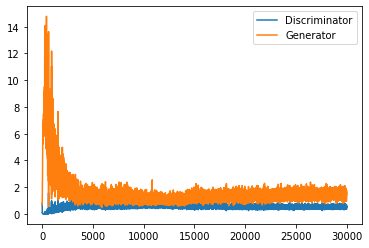

In [ ]:
plt.plot(d_loss , label = "Discriminator")
plt.plot(g_loss , label = "Generator")
plt.legend()

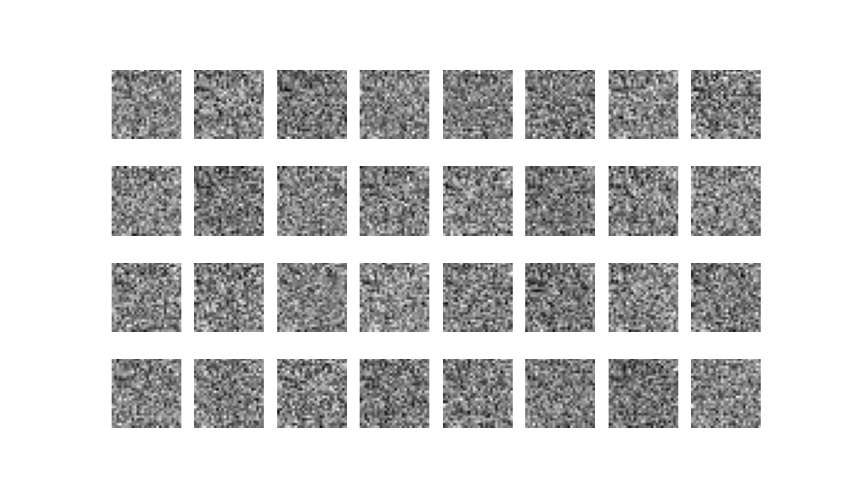

In [ ]:
plt.figure(figsize= (15 , 10))
plt.imshow(plt.imread("0.png"))
plt.axis("off");

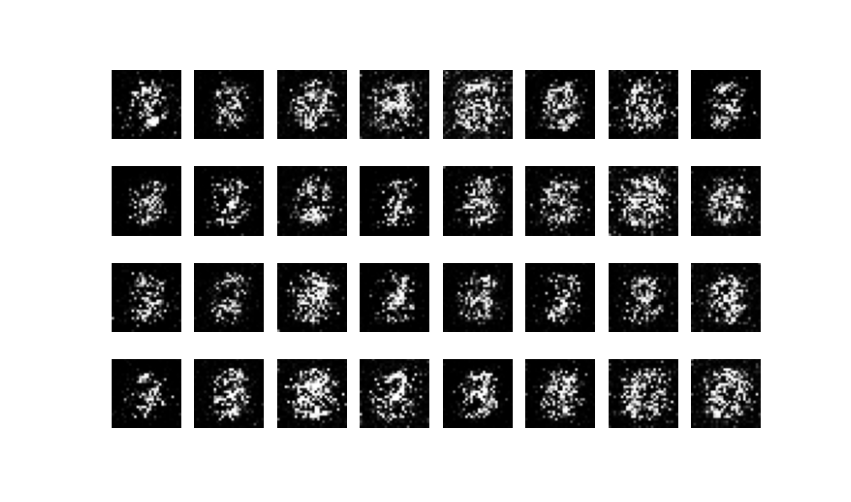

In [ ]:
plt.figure(figsize= (15 , 10))
plt.imshow(plt.imread("1000.png"))
plt.axis("off");

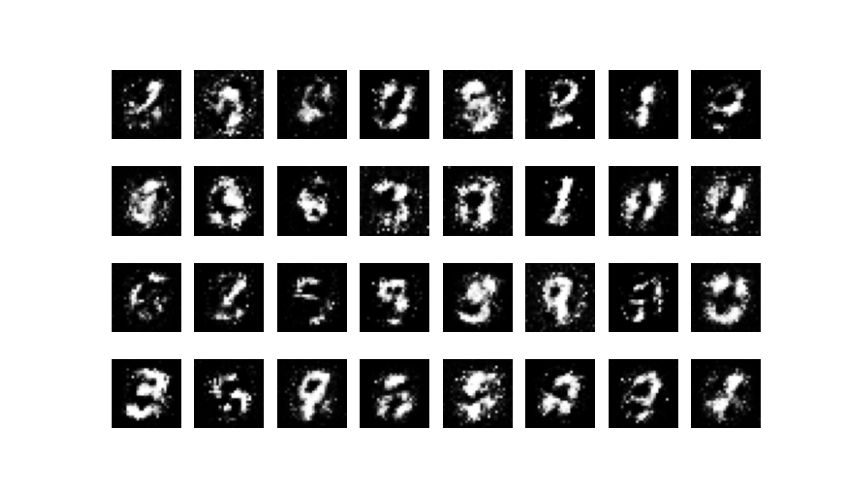

In [ ]:
plt.figure(figsize= (15 , 10))
plt.imshow(plt.imread("5000.png"))
plt.axis("off");

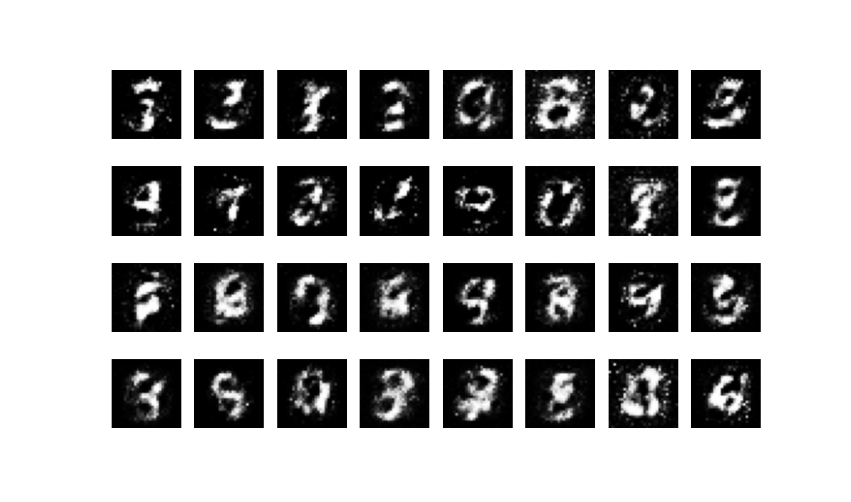

In [ ]:
plt.figure(figsize= (15 , 10))
plt.imshow(plt.imread("10000.png"))
plt.axis("off");

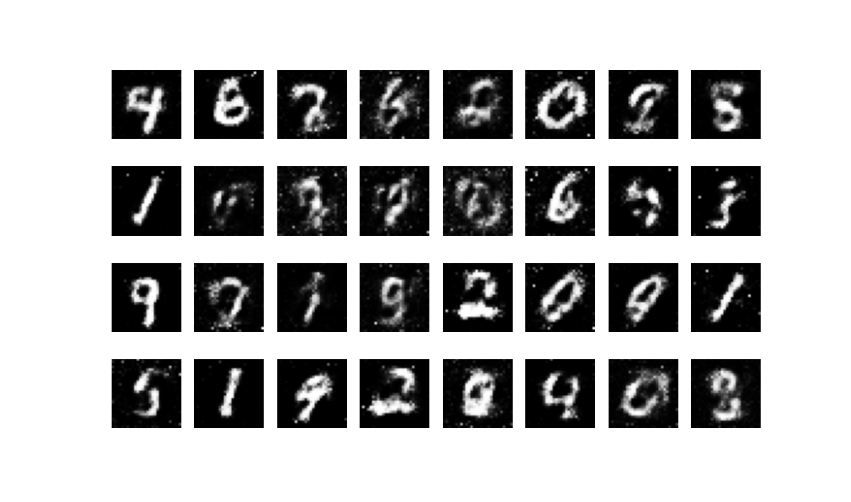

In [ ]:
plt.figure(figsize= (15 , 10))
plt.imshow(plt.imread("20000.png"))
plt.axis("off");

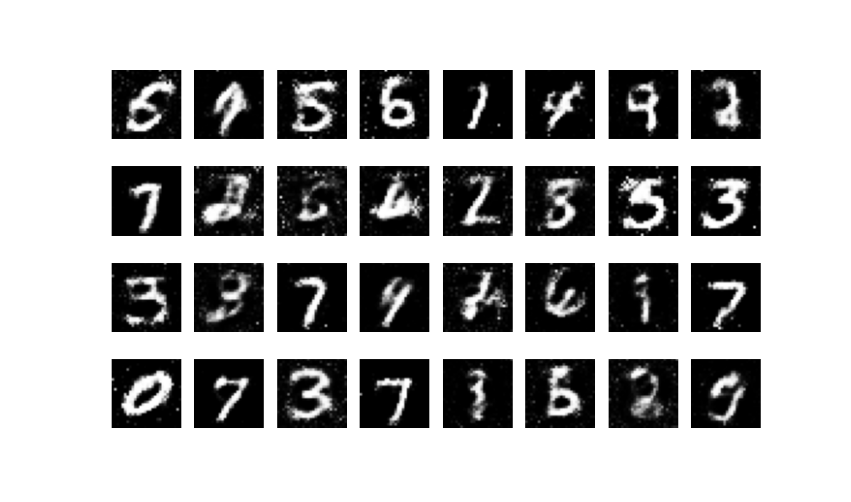

In [ ]:
plt.figure(figsize= (15 , 10))
plt.imshow(plt.imread("25000.png"))
plt.axis("off");

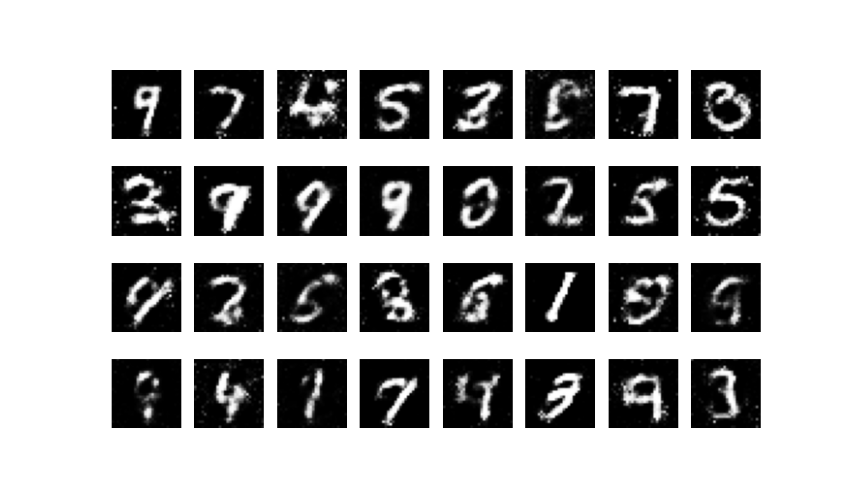

In [ ]:
plt.figure(figsize= (15 , 10))
plt.imshow(plt.imread("29800.png"))
plt.axis("off");

## Giving random noise and predicting using generator model

In [ ]:
a = np.array(generator.predict(np.random.randn(50 , gen_dim))).reshape(50 , 28 , 28)

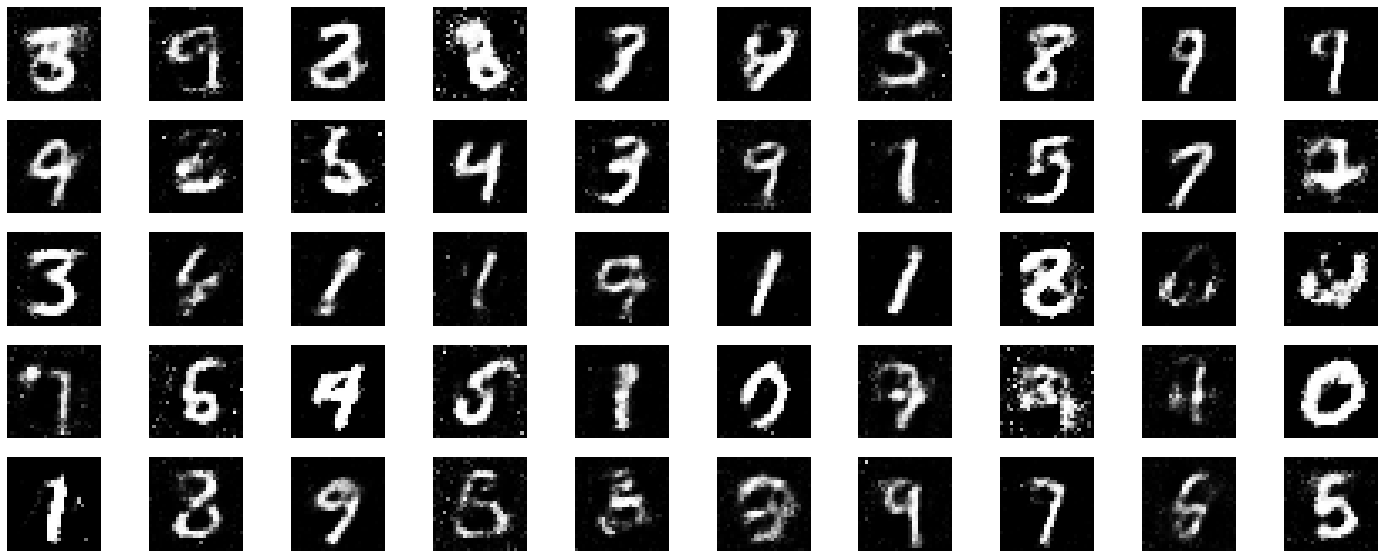

In [ ]:
plt.figure(figsize = (25 ,10))
for i in range(50):
    plt.subplot(5 ,10 , i+1)
    plt.imshow(a[i] , cmap = "gray")
    plt.axis("off");

In [ ]:
discriminator.predict(a.reshape(-1 , 784))

array([[0.22032318],
       [0.15841264],
       [0.49109888],
       [0.14739099],
       [0.08924091],
       [0.17212617],
       [0.2207416 ],
       [0.32196242],
       [0.15501338],
       [0.25521266],
       [0.5645075 ],
       [0.01543137],
       [0.39908338],
       [0.56658226],
       [0.71735567],
       [0.14912763],
       [0.08229268],
       [0.39235687],
       [0.4764823 ],
       [0.3458757 ],
       [0.64158756],
       [0.03416809],
       [0.5074689 ],
       [0.16321495],
       [0.1968149 ],
       [0.36725426],
       [0.19636297],
       [0.6159798 ],
       [0.09959203],
       [0.13313726],
       [0.40570194],
       [0.5024842 ],
       [0.38472915],
       [0.2562045 ],
       [0.25928867],
       [0.22826883],
       [0.26644072],
       [0.0418148 ],
       [0.19478953],
       [0.3219276 ],
       [0.05054313],
       [0.33170313],
       [0.43631452],
       [0.11283061],
       [0.11128473],
       [0.1155262 ],
       [0.471928  ],
       [0.201

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

In [ ]:
gen = load_model("generator.h5" , custom_objects= {'LeakyReLU': LeakyReLU(0.2)},compile= False)

In [ ]:
p = gen.predict(np.random.randn(10 , 100))

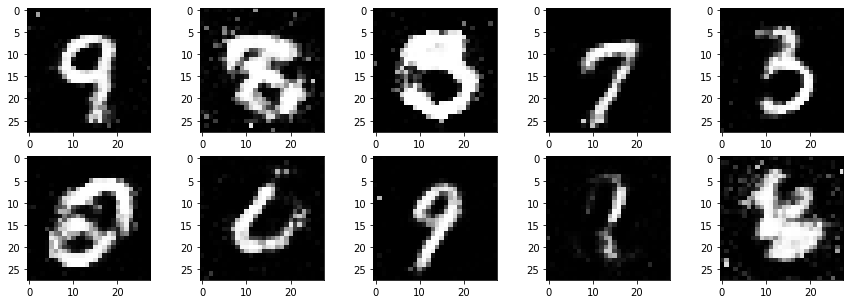

In [ ]:
plt.figure(figsize = (15 , 5))
for i in range(10):
    plt.subplot(2 , 5 , i +1)
    plt.imshow(p[i].reshape(28 , 28) , cmap = "gray")